In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Reshape, Dropout
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam

warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


In [2]:
ratings = pd.read_csv("goodbooks-10k/ratings.csv")

In [3]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
ratings.shape

(981756, 3)

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.2, random_state=64)

In [6]:
train.head(3)

,book_id,user_id,rating
137788,1379,5229,3
432152,4329,19194,3
318113,3184,31018,4


In [7]:
test.head(3)

,book_id,user_id,rating
613794,6164,21787,4
494656,4959,31304,5
874919,8854,580,2


In [8]:
n_users = len(ratings.user_id.unique())
n_books = len(ratings.book_id.unique())
n_latent_factors  = 5

n_users, n_books

(53424, 10000)

In [78]:
book_input = Input(shape=(1,), name='Book-Input')
book_embedding = Embedding(n_books+1, n_latent_factors, name='Book-Embedding')(book_input)
book_vec = Flatten(name='Flattern-Books')(book_embedding)

user_input = Input(shape=(1,), name='User-Input')
user_embedding = Embedding(n_users+1, n_latent_factors, name='User-Embedding')(user_input)
user_vec = Flatten(name='Flattern-Users')(user_embedding)

prod = Dot(axes=1, name="Dot-Product")([book_vec, user_vec])
model = Model(inputs=[book_input, user_input], outputs=prod)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

model.fit(x=[train.book_id, train.user_id], 
          y=train.rating, 
          epochs=10, 
          validation_data=[[test.book_id, test.user_id], test.rating], 
          batch_size=512)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 5)         50005       Book-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         267125      User-Input[0][0]                 
____________________________________________________________________________________________

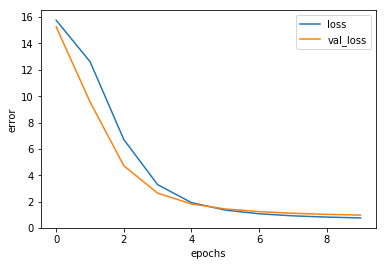

In [178]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('epochs')
plt.ylabel('error')
plt.show()

In [35]:
book_factors = 32
user_factors = 8

book_input = Input(shape=(1,), name='Book-Input')
book_embedding = Embedding(n_books+1, book_factors, name='Book-Embedding')(book_input)
book_vec = Flatten(name='Flattern-Books')(book_embedding)

user_input = Input(shape=(1,), name='User-Input')
user_embedding = Embedding(n_users+1, user_factors, name='User-Embedding')(user_input)
user_vec = Flatten(name='Flattern-Users')(user_embedding)

conc = Concatenate()([book_vec, user_vec])

fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

model2 = Model(inputs=[book_input, user_input], outputs=out)
model2.compile(optimizer='adam', loss='mean_squared_error')
model2.summary()

model2.fit(x=[train.book_id, train.user_id], 
          y=train.rating, 
          epochs=4, 
          validation_data=[[test.book_id, test.user_id], test.rating], 
          batch_size=512)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 32)        320032      Book-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 8)         427400      User-Input[0][0]                 
____________________________________________________________________________________________

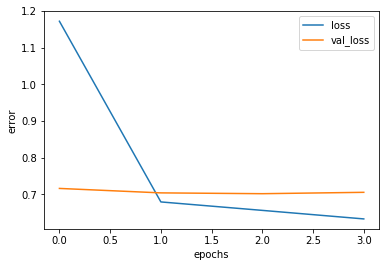

In [36]:
plt.plot(model2.history.history['loss'])
plt.plot(model2.history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('epochs')
plt.ylabel('error')
plt.show()

In [39]:
book_data = ratings.book_id.unique()
user = np.repeat(314, len(book_data))
predictions = model2.predict([user, book_data]).reshape(-1)

recommendations = (-predictions).argsort()[:10]
recommendations

array([ 818, 3955, 4441, 8064, 5269, 8642, 4843, 5526, 1234, 7119],
      dtype=int64)

In [40]:
predictions[recommendations]

array([5.4019456, 5.315578 , 5.3074775, 5.2953286, 5.288089 , 5.270898 ,
       5.263783 , 5.2606435, 5.2550693, 5.252222 ], dtype=float32)

In [41]:
books = pd.read_csv('goodbooks-10k/books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [42]:
recommended_books = books[books.id.isin(recommendations)]
recommended_books[['title', 'authors', 'original_publication_year']]

,title,authors,original_publication_year
817,Dreamcatcher,"Stephen King, William Olivier Desmond",2001.0
1233,Sybil: The Classic True Story of a Woman Posse...,Flora Rheta Schreiber,1973.0
3954,The Book of Unknown Americans,Cristina Henriquez,2014.0
4440,The Aleph and Other Stories,"Jorge Luis Borges, Andrew Hurley",1947.0
4842,Salt Sugar Fat: How the Food Giants Hooked Us,Michael Moss,2013.0
5268,Fermat's Enigma: The Epic Quest to Solve the W...,Simon Singh,1997.0
5525,Flush,Carl Hiaasen,2005.0
7118,"The Ship Who Sang (Brainship, #1)",Anne McCaffrey,1969.0
8063,The Smartest Guys in the Room: The Amazing Ris...,"Bethany McLean, Peter Elkind",2003.0
8641,"Rival (Fall Away, #2)","Penelope Douglas, Abby Craden, Nelson Hobbs",2014.0


## Book Similarities

In [43]:
book_layer = model2.get_layer('Book-Embedding')
book_weights = book_layer.get_weights()[0]
book_weights.shape

(10001, 32)

In [68]:
compare_book_id = 432
book_weight = book_weights[compare_book_id]
similiarities = (book_weights @ book_weight) / np.linalg.norm(book_weights, axis = 1)
similiarities = (-similiarities).argsort()[:10]


recommended_books = books[books.id.isin(similiarities)]
recommended_books[['title', 'authors', 'original_publication_year']]

,title,authors,original_publication_year
431,"I, Robot (Robot #0.1)",Isaac Asimov,1950.0
892,"Fullmetal Alchemist, Vol. 1 (Fullmetal Alchemi...","Hiromu Arakawa, Akira Watanabe",2002.0
1307,A Court of Mist and Fury (A Court of Thorns an...,Sarah J. Maas,2016.0
2150,Saga #1,"Brian K. Vaughan, Fiona Staples",2012.0
2166,"Empire of Storms (Throne of Glass, #5)",Sarah J. Maas,2016.0
3227,Salt to the Sea,Ruta Sepetys,2016.0
5657,All Things Wise and Wonderful,James Herriot,1976.0
6994,The Peacegiver: How Christ Offers to Heal Our ...,James L. Ferrell,2004.0
7038,The Brothers Lionheart,"Astrid Lindgren, Ilon Wikland, Jill M. Morgan",1973.0
7116,Life Together: The Classic Exploration of Chri...,Dietrich Bonhoeffer,1939.0


In [66]:
books[books.title.str.contains('robot', case=False)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
431,432,41804,41804,1796026,218,553803700,9.780554e+12,Isaac Asimov,1950.0,"I, Robot",...,198368,210219,4335,1221,5332,35107,82535,86024,https://images.gr-assets.com/books/1388321463m...,https://images.gr-assets.com/books/1388321463s...
1913,1914,41811,41811,140376,139,586008357,9.780586e+12,Isaac Asimov,1954.0,The Caves of Steel,...,51059,58121,1689,212,1282,10553,24246,21828,https://images.gr-assets.com/books/1335782224m...,https://images.gr-assets.com/books/1335782224s...
3753,3754,30016,30016,1583154,109,586010165,9.780586e+12,Isaac Asimov,1957.0,The Naked Sun,...,26532,31536,913,61,584,5820,14039,11032,https://images.gr-assets.com/books/1335782263m...,https://images.gr-assets.com/books/1335782263s...
3977,3978,41810,41810,905286,85,553299492,9.780553e+12,Isaac Asimov,1983.0,The Robots of Dawn,...,26075,29192,840,103,677,5409,12275,10728,https://images.gr-assets.com/books/1351030933m...,https://images.gr-assets.com/books/1351030933s...
5781,5782,76688,76688,1932588,30,586062009,9.780586e+12,Isaac Asimov,1985.0,Robots and Empire,...,18462,20076,446,56,430,3468,8256,7866,https://images.gr-assets.com/books/1335782304m...,https://images.gr-assets.com/books/1335782304s...
9757,9758,50091,50091,2361910,36,586057242,9.780586e+12,Isaac Asimov,1982.0,The Complete Robot,...,10362,11162,286,30,112,1351,4169,5500,https://images.gr-assets.com/books/1405467461m...,https://images.gr-assets.com/books/1405467461s...


In [212]:
from sklearn.manifold import TSNE
import umap

def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return umap.UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [213]:
book_r = reduce_dim(book_weights, components = 2, method = 'umap')

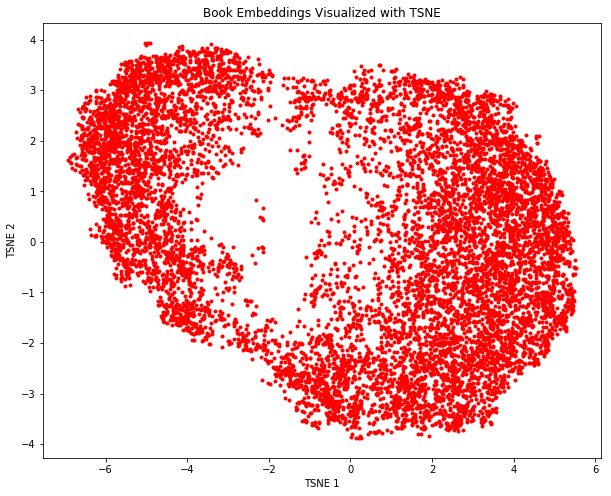

In [215]:
plt.figure(figsize = (10, 8))
plt.plot(book_r[:, 0], book_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Book Embeddings Visualized with TSNE');

In [216]:
top_authors = books.authors.value_counts()
top_authors = top_authors[top_authors > 40]
top_authors.keys()

Index(['Stephen King', 'Nora Roberts', 'Dean Koontz', 'Terry Pratchett'], dtype='object')

In [217]:
a = books['authors'].copy()
a = a.append(pd.Series(['Slava Spirin'], index=[10000]))

a = a.map({'Stephen King':0, 'Nora Roberts':1, 'Dean Koontz':2, 'Terry Pratchett':3})
# a = a[a>0]
colormap = np.array(['b','b', 'g', 'r', 'y'])
# plt.figure(figsize = (10, 8))
# plt.scatter(book_r[:, 0], book_r[:, 1], c=a)
# plt.xlabel('TSNE 1')
# plt.ylabel('TSNE 2')
# plt.title('Book Embeddings Visualized with TSNE')
b = np.array((a[a>0]), dtype='int')

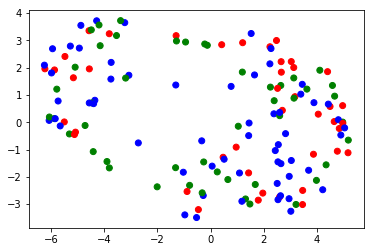

In [218]:
plt.scatter(book_r[a>0, 0], book_r[a>0, 1], c=colormap[b])